In [1]:
import os
os.chdir("/content/drive/MyDrive/DataScience/PROJECT/2022_Time_Series/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm
from typing import Optional, Tuple

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

In [5]:
with open('data/pv_imputation.pickle', 'rb') as f:
    pv = pickle.load(f)

In [6]:
pv['x_time'] = [int(i.split(' ')[1]) for i in pv['time']]

# scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [9]:
x_features = ['alt', 'azi', 'rad', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'x_time']

x_scaler = MinMaxScaler()
x_scaler.fit(pv[x_features])
pv[x_features] = x_scaler.transform(pv[x_features])

In [10]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,18,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,18,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

pv_val_criterion = pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]
pv_test_criterion = pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]

In [ ]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

pv_val_criterion = pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]
pv_test_criterion = pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]

# data loader

In [11]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [12]:
# weight init 0.01 -> 0.1로 증가

# 뒷부분 padding 제외하는 함수
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding) # 뒷 padding 부분 제거?
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)] 

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [13]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.1)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1.transpose(1, 2))

# data component 2

In [14]:
iw = 6
ow = 6
stride = 6
num_feature = len(x_features)+1

train_dataset = windowDataset(pv_train[['power_scale']+x_features], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=stride)
valid_dataset = windowDataset(pv_val[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=stride)
test_dataset = windowDataset(pv_test[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=stride)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(1335, 6, 11)
(1335, 6, 1)
(80, 6, 11)
(80, 6, 1)
(44, 6, 11)
(44, 6, 1)


In [15]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 6, 11])
torch.Size([64, 6, 1])


In [16]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.permute(0,2,1).to(device).float().contiguous()
        y = y.permute(0,2,1).to(device).float().contiguous()

        out = model(x).permute(0,2,1)

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"pred shape: {out.shape}")
        # print(f"final y shape: {y[:,0,:y.shape[2]].shape}")
        # print(f"final pred shape: {out[:,0,:y.shape[2]].shape}")

        loss = criterion(y[:,0,-stride:], out[:,0,-stride:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return out.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        x = x.permute(0,2,1).to(device).float()
        y = y.permute(0,2,1).to(device).float()

        with torch.no_grad():
            out = model(x).permute(0,2,1)
        outputs.append(list(out.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(y[:,0,-stride:], out[:,0,-stride:])
        # loss = criterion(y, out)
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)
    # print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    if file_name:
        torch.save(model.state_dict(), file_name)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

In [17]:
# wandb.init(name='base', project="TCN", entity="yyyyyjkim")

In [19]:
# pv 만 예측하는 경우 output_size=1
# 기상 정보 같이 예측하는 경우 output_size=input_size -> x 

param_config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "input_size": len(x_features),
    "output_size": 1,
    "num_channels": [len(x_features)]*2,
    "kernel_size": 3, 
    "dropout": 0.2
}

In [20]:
device='cuda'
model = TCN(input_size=param_config['input_size'], output_size=param_config['output_size'], num_channels=param_config['num_channels'], 
            kernel_size=param_config['kernel_size'], dropout=param_config['dropout']).to(device)
optimizer = optim.Adam(model.parameters(), lr=param_config['learning_rate'])
criterion = nn.MSELoss()

In [21]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,552 trainable parameters


In [22]:
# wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(param_config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device=device)
    *result_val, val_loss = predict(model, val_loader, criterion, device=device)
    *result_test, test_loss = predict(model, test_loader, criterion, device=device)

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.09927 / test_loss: 0.06991
epoch: 1 / val_loss: 0.07583 / test_loss: 0.05530
epoch: 2 / val_loss: 0.05396 / test_loss: 0.04223
epoch: 3 / val_loss: 0.04055 / test_loss: 0.04012
epoch: 4 / val_loss: 0.03170 / test_loss: 0.03643
epoch: 5 / val_loss: 0.02640 / test_loss: 0.03120
epoch: 6 / val_loss: 0.02360 / test_loss: 0.03637
epoch: 7 / val_loss: 0.02180 / test_loss: 0.03770
epoch: 8 / val_loss: 0.02030 / test_loss: 0.03805
epoch: 9 / val_loss: 0.01900 / test_loss: 0.03589
epoch: 10 / val_loss: 0.01820 / test_loss: 0.03616
epoch: 11 / val_loss: 0.01691 / test_loss: 0.03327
epoch: 12 / val_loss: 0.01617 / test_loss: 0.03324
epoch: 14 / val_loss: 0.01572 / test_loss: 0.03231
epoch: 16 / val_loss: 0.01529 / test_loss: 0.03190
epoch: 17 / val_loss: 0.01446 / test_loss: 0.03039
epoch: 20 / val_loss: 0.01416 / test_loss: 0.02984
epoch: 23 / val_loss: 0.01405 / test_loss: 0.03033
epoch: 24 / val_loss: 0.01336 / test_loss: 0.02873
epoch: 32 / val_loss: 0.01331 / test_loss

In [ ]:
# wandb.finish()

# result

In [23]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,0,-stride:].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,0,-stride:].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

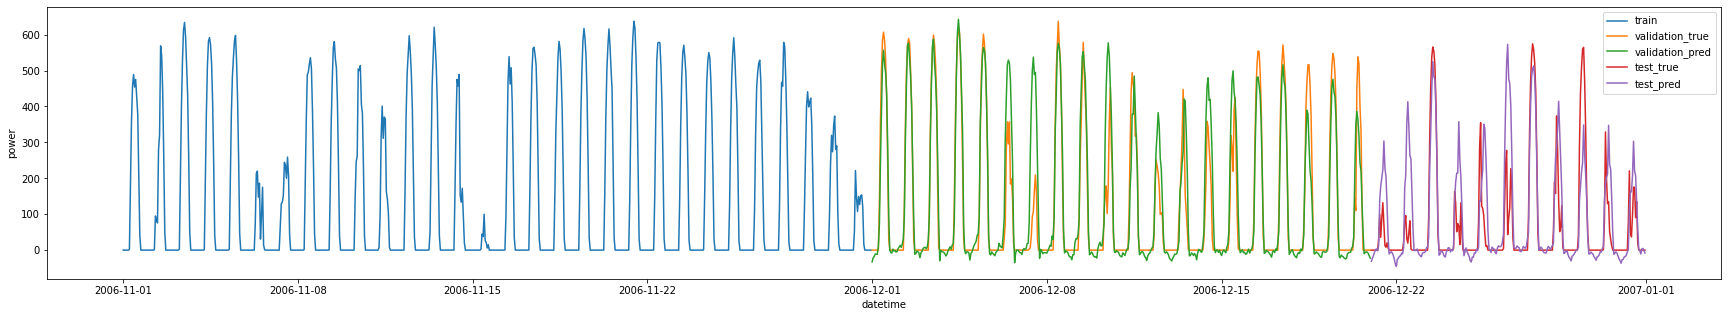

In [24]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [25]:
print(f"validation RMSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred'])**0.5:.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"test RMSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred'])**0.5:.5f}")
print(f"test R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation RMSE: 79.88074
validation R2: 0.82221
test RMSE: 104.61797
test R2: 0.43274


In [26]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, criterion, device=device)
*result_test, test_loss = predict(model, test_loader, criterion, device=device)

In [27]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,0,-stride:].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,0,-stride:].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

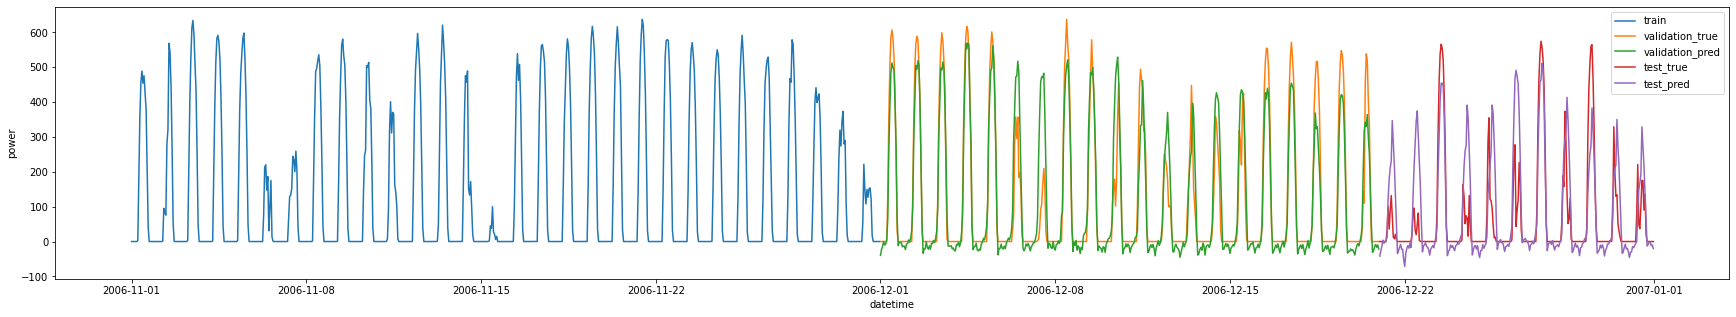

In [28]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [29]:
print(f"validation RMSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred'])**0.5:.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"test RMSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred'])**0.5:.5f}")
print(f"test R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation RMSE: 75.35410
validation R2: 0.84179
test RMSE: 106.01755
test R2: 0.41746
